In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

In [114]:
data = pd.read_excel('flight_data.xlsx')

In [115]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [117]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [118]:
data.shape

(10683, 11)

In [119]:
data[data['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [120]:
data.dropna(inplace = True)

In [121]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### Pre-process and Featurize "Date_of_Journey"

To enhance the dataset, we will pre-process the "Date_of_Journey" feature. This involves extracting and creating new features for the day, month, and year, allowing for more granular analysis and modeling.

#### Steps Involved:

1. **Convert to Datetime**: Transform the "Date_of_Journey" column into a datetime format for accurate parsing.

2. **Extract Day**: Create a new feature, "Journey_Day," capturing the day of the month from the journey date.

3. **Extract Month**: Create "Journey_Month," representing the month of the year extracted from the journey date.

4. **Extract Year**: Optionally create "Journey_Year" if analyzing trends over multiple years, though it might be redundant for datasets spanning a single year.

By breaking down the journey date into these components, we improve the model's ability to capture temporal patterns and enhance predictive performance.

In [122]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [123]:
# Define a Function to Convert Columns to Datetime Format

def change_into_datetime(col):
    # Convert the specified column to datetime format
    data[col] = pd.to_datetime(data[col])

In [124]:
# Apply the Datetime Conversion to Relevant Columns

# Convert the 'Date_of_Journey', 'Dep_Time', and 'Arrival_Time' columns to datetime format
for feature in ['Date_of_Journey', 'Dep_Time', 'Arrival_Time']:
    change_into_datetime(feature)

In [125]:
data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [126]:
data['Date_of_Journey'].min()

Timestamp('2019-01-03 00:00:00')

In [127]:
data['Date_of_Journey'].max()

Timestamp('2019-12-06 00:00:00')

In [128]:
# Extract Day, Month, and Year from 'Date_of_Journey'

# Extract the day from 'Date_of_Journey' and create a new column 'Journey_Day'
data['Journey_Day'] = data['Date_of_Journey'].dt.day

# Extract the month from 'Date_of_Journey' and create a new column 'Journey_Month'
data['Journey_Month'] = data['Date_of_Journey'].dt.month

# Extract the year from 'Date_of_Journey' and create a new column 'Journey_Year'
data['Journey_Year'] = data['Date_of_Journey'].dt.year

In [129]:
data.drop('Date_of_Journey',axis=1,inplace=True)

In [130]:
data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-11 22:20:00,2025-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-11 05:50:00,2025-03-11 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2025-03-11 09:25:00,2025-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2025-03-11 18:05:00,2025-03-11 23:30:00,5h 25m,1 stop,No info,6218,5,12,2019
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2025-03-11 16:50:00,2025-03-11 21:35:00,4h 45m,1 stop,No info,13302,3,1,2019


### Clean and Featurize "Dep_Time" and "Arrival_Time"

To improve data quality and enhance feature richness, we'll clean and featurize the "Dep_Time" and "Arrival_Time" columns. This process will extract meaningful components from these time-related features.

### Steps Involved:

1. **Convert to Datetime Format**: Ensure that both "Dep_Time" and "Arrival_Time" are in a standardized datetime format for consistent processing.

2. **Extract Hour**: Create new features "Dep_Hour" and "Arrival_Hour" to represent the hour of departure and arrival, respectively. This helps capture patterns related to different times of the day.

3. **Extract Minute**: Similarly, extract "Dep_Minute" and "Arrival_Minute" to capture finer temporal details.

4. **Categorize Time of Day**: Optionally, categorize departure and arrival times into segments like "Morning," "Afternoon," "Evening," and "Night" to identify trends based on time-of-day preferences.

By processing these time features, we aim to enhance the predictive power of the dataset by uncovering underlying temporal patterns.

In [131]:
# Define a Function to Extract Hour and Minute from a Datetime Column

def extract_hour_min(df, col):
    # Extract the hour from the specified datetime column and create a new column with '_Hour' suffix
    df[col + '_Hour'] = df[col].dt.hour

    # Extract the minute from the specified datetime column and create a new column with '_Minute' suffix
    df[col + '_Minute'] = df[col].dt.minute

    # Drop the original datetime column from the DataFrame
    df.drop(col, axis=1, inplace=True)

    return df.head(2)

In [132]:
# Departure time is when a plane leaves the gate

extract_hour_min(data,'Dep_Time')

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-11 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50


In [133]:
# Arrival time is when the plane pulls up to the gate

extract_hour_min(data,'Arrival_Time')

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15


In [134]:
# Define a Function to Categorize Departure Time into Time of Day

def flight_dep_time(x):
    '''
    This function categorizes the flight departure hour into a time of day.
    It takes an hour integer as input and returns a corresponding part of the day.
    '''

    # Check if the hour is between 4 and 8, inclusive, and return 'Early Morning'
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    
    # Check if the hour is between 8 and 12, inclusive, and return 'Morning'
    elif (x > 8) and (x <= 12):
        return 'Morning'
    
    # Check if the hour is between 12 and 16, inclusive, and return 'Noon'
    elif (x > 12) and (x <= 16):
        return 'Noon'
    
    # Check if the hour is between 16 and 20, inclusive, and return 'Evening'
    elif (x > 16) and (x <= 20):
        return 'Evening'
    
    # Check if the hour is between 20 and 24, inclusive, and return 'Night'
    elif (x > 20) and (x <= 24):
        return 'Night'
    
    # If the hour doesn't match any of the above, return 'Late Night'
    else:
        return 'Late Night'

In [135]:
cf.go_offline()

In [136]:
data['Dep_Time_Hour'].apply(flight_dep_time).value_counts().iplot(kind='bar')

### Visualization of Flight Departure Times

The following bar chart provides a visual representation of flight departures categorized by time of day. This helps identify patterns in flight scheduling and passenger preferences.

#### Description

- **Categories**: Departure times are categorized into segments such as "Early Morning," "Morning," "Noon," "Evening," "Night," and "Late Night."
- **Purpose**: Understanding when most flights are scheduled can assist in optimizing operations and enhancing passenger experience.
  
#### Key Observations

- The most frequent departures occur during the "Early Morning" and "Evening" periods.
- Fewer flights are scheduled during "Late Night," possibly due to passenger convenience or operational constraints.

In [137]:
data.head(10)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
5,SpiceJet,Kolkata,Banglore,CCU → BLR,2h 25m,non-stop,No info,3873,24,6,2019,9,0,11,25
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,15h 30m,1 stop,In-flight meal not included,11087,3,12,2019,18,55,10,25
7,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,21h 5m,1 stop,No info,22270,3,1,2019,8,0,5,5
8,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,25h 30m,1 stop,In-flight meal not included,11087,3,12,2019,8,55,10,25
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,7h 50m,1 stop,No info,8625,27,5,2019,11,25,19,15


### Pre-process and Featurize the "Duration" Feature

To enhance our machine learning model's ability to interpret the "Duration" feature, we need to pre-process and convert it into meaningful numerical components.

#### Steps Involved:

1. **Pre-process "Duration"**:
   - Clean the data by ensuring each entry in the "Duration" column contains both hours and minutes, even filling missing parts with zeros if needed.

2. **Feature Extraction**:
   - **Duration Hours**: Extract the hour component and create a new feature called "Duration_Hours."
   - **Duration Minutes**: Extract the minute component and create a new feature called "Duration_Minutes."

3. **Purpose**:
   - Transforming the "Duration" from a string format into numerical values allows the machine learning model to effectively process and utilize this information.
   - By clearly defining "Duration_Hours" and "Duration_Minutes," we provide a structured input that enhances model training and prediction accuracy.

This preprocessing step is crucial because it aligns the dataset with the model's requirements, ensuring that the "Duration" feature is both interpretable and useful.

In [138]:
# Define a Function to Preprocess Flight Duration Strings

def preprocess_duration(x):
    '''
    This function ensures that the flight duration string contains both hours and minutes.
    If not, it adds missing components (hours or minutes) with a default value of 0.
    '''
    
    # Check if 'h' (hours) is not in the string; if missing, prefix with '0h'
    if 'h' not in x:
        x = '0h ' + x
    
    # Check if 'm' (minutes) is not in the string; if missing, append '0m'
    elif 'm' not in x:
        x = x + ' 0m'
        
    return x

In [139]:
data['Duration'] = data['Duration'].apply(preprocess_duration)

In [140]:
data['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

In [141]:
# Split the 'Duration' Column and Extract Hours and Minutes

# Example: Splitting the first entry in 'Duration' to get the hour part
# Splits the string on space and takes the first part (e.g., '2h' from '2h 50m')
data['Duration'][0].split(' ')[0]

# Convert the hour part to an integer by removing the 'h' character
int(data['Duration'][0].split(' ')[0][0:-1])

# Convert the minute part to an integer by removing the 'm' character
int(data['Duration'][0].split(' ')[1][0:-1])

# Extract hours from the 'Duration' column for all entries
data['Duration_Hours'] = data['Duration'].apply(lambda x: int(x.split(' ')[0][0:-1]))

# Extract minutes from the 'Duration' column for all entries
data['Duration_Mins'] = data['Duration'].apply(lambda x: int(x.split(' ')[1][0:-1]))

In [142]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45


In [143]:
# Convert 'Duration' to Total Minutes

# Replace 'h' with '*60' to convert hours to minutes
# Replace spaces with '+' to prepare for evaluation as a mathematical expression
# Replace 'm' with '*1' to treat minutes properly
# Use eval() to calculate the total minutes from the expression
data['Duration_Total_Mins'] = data['Duration']\
    .str.replace('h', '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

In [144]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins,Duration_Total_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25,445


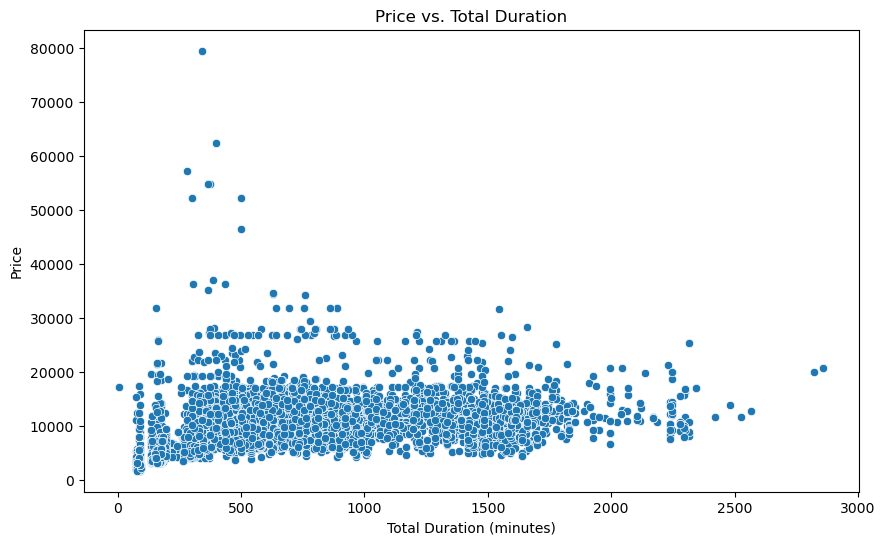

In [145]:
# Relationship between Price and Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration_Total_Mins', y='Price', data=data)
plt.title('Price vs. Total Duration')
plt.xlabel('Total Duration (minutes)')
plt.ylabel('Price')
plt.show()

### Scatter Plot: Price vs. Total Duration

This scatter plot illustrates the relationship between flight prices and total flight durations.

#### Key Insights

- **Trend Analysis**: There appears to be a slight clustering of data points, indicating that most flights are priced within a certain range for varying durations.
- **Outliers**: Some flights have significantly higher prices despite varying durations, which could indicate premium services or last-minute bookings.
- **Duration Range**: Most flights fall within a total duration of up to 1000 minutes, with prices staying relatively consistent across this range.

#### Conclusion

Understanding the relationship between price and duration can assist airlines in pricing strategy and travelers in choosing flights based on budget and time constraints.

In [146]:
data['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [147]:
# Combine "New Delhi" and "Delhi" into "Delhi"
data['Destination'] = data['Destination'].replace({'New Delhi': 'Delhi'})

<AxesSubplot:title={'center':'Distribution of Destinations'}>

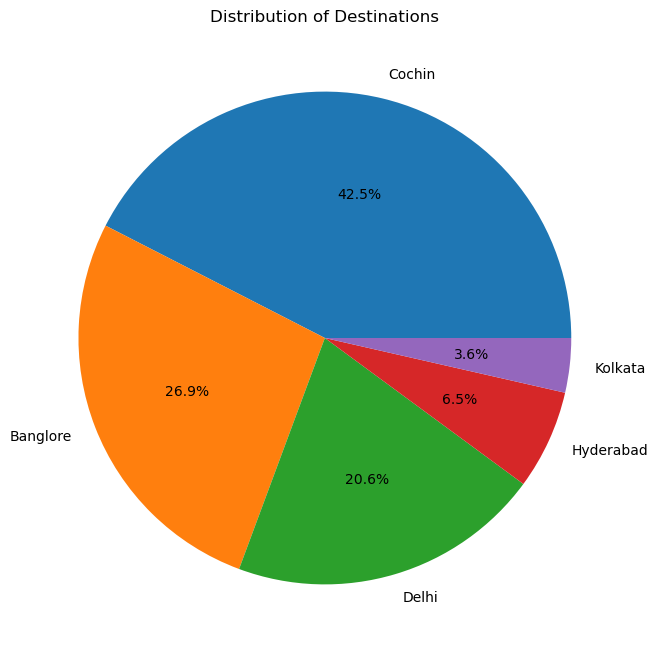

In [148]:
data['Destination'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',
    title='Distribution of Destinations',
    ylabel='',
    figsize=(8, 8)
)

### Pie Chart: Distribution of Flight Destinations

This pie chart provides a visual summary of the distribution of flights across various destination cities.

#### Key Insights

- **Dominant Destinations**:
  - Cochin and Banglore have the highest number of flights, indicating popular travel routes or hubs.
- **Lesser Traffic**:
  - Cities like Kolkata and Hyderabad have fewer flights, possibly due to lower demand or fewer direct routes.

#### Exploring the Data

By examining this distribution, airlines and travel agencies can better understand travel patterns and optimize routes accordingly.

In [149]:
data['Route']

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

### Bivariate Analysis

#### Objective
Perform a bivariate analysis to uncover business insights related to flight route usage, specifically identifying the most frequent routes for Jet Airways.

#### Problem Statement

**Which routes are most frequently used by Jet Airways?**

- **Purpose**: Understanding Jet Airways' popular routes can help optimize scheduling, marketing strategies, and resource allocation.

### Approach

1. **Filter Data**:
   - Extract flights operated by Jet Airways from the dataset.

2. **Analyze Route Frequencies**:
   - Use value counts to determine the most traveled routes by Jet Airways.

3. **Visualize Findings**:
   - Plot the data to easily interpret the most popular routes.

By identifying these key routes, the airline can enhance operational efficiencies and cater better to customer demands.

In [150]:
# Filter Data for 'Jet Airways' and Analyze Route Frequencies

# Filter the DataFrame to include only rows where the 'Airline' is 'Jet Airways'
jet_airways_data = data[data['Airline'] == 'Jet Airways']

# Group the filtered data by the 'Route' column and count the number of occurrences for each route
route_counts = jet_airways_data.groupby('Route').size()

# Sort the resulting counts in descending order to find the most common routes
sorted_route_counts = route_counts.sort_values(ascending=False)

# Display the sorted route counts
sorted_route_counts

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

### Airline vs. Price Analysis

#### Objective
Analyze the price distribution and obtain a five-point summary for each airline to gain insights into pricing strategies and competitive positioning.

#### Key Insights

1. **Price Distribution**:
   - Understand the spread and variance of ticket prices across different airlines.

2. **Five-Point Summary**:
   - Calculate statistical measures (minimum, first quartile, median, third quartile, maximum) for each airline to summarize their pricing structures.

#### Approach

1. **Data Exploration**:
   - Use descriptive statistics to analyze the price data for each airline.

2. **Visualization**:
   - Plot box plots to visually assess price distributions and identify potential outliers.

#### Benefits

- **Strategic Planning**: Helps airlines adjust pricing strategies to stay competitive.
- **Consumer Insights**: Provides travelers with a clearer understanding of pricing norms among various carriers.

This analysis serves as a foundation for strategic decisions in revenue management and market analysis.

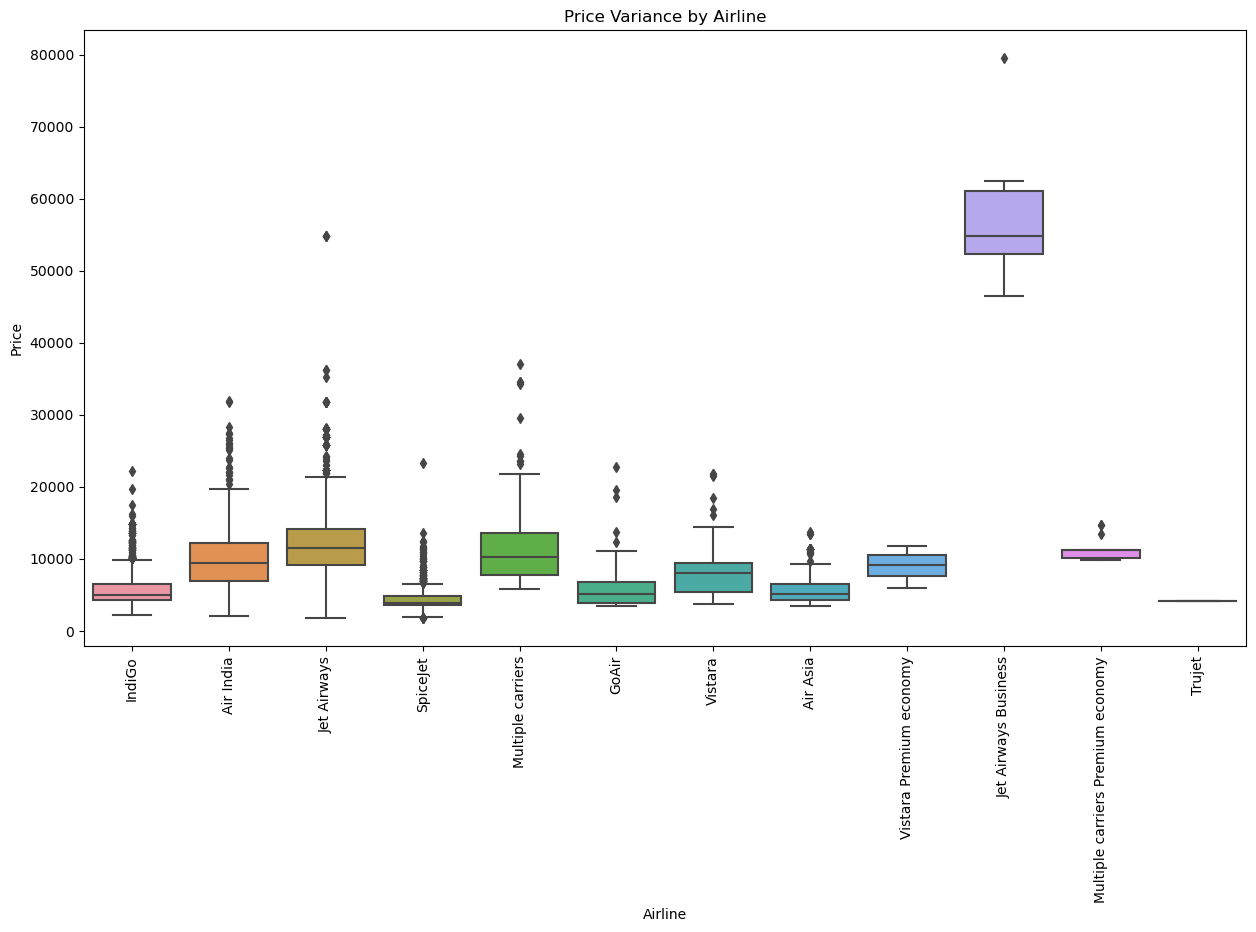

In [151]:
# Categorical Feature Analysis - Airline
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'Airline', y = 'Price', data = data)
plt.title('Price Variance by Airline')
plt.xticks(rotation = 90)
plt.show()

### Box Plot: Price Variance by Airline

This box plot illustrates the variance in ticket prices across different airlines, providing insights into their pricing strategies.

#### Key Observations

- **Median Price**:
  - The line inside each box represents the median price, showing the central tendency for each airline.

- **Interquartile Range (IQR)**:
  - The box spans the first to the third quartile, indicating the middle 50% of prices. Wider boxes suggest more variance in pricing.

- **Outliers**:
  - Points outside the whiskers indicate outliers, representing extreme price values. Airlines like Jet Airways show significant outliers due to premium services.

- **Price Distribution**:
  - Significant variance exists among airlines, with some offering more competitive rates while others cater to premium markets.

#### Insights for Strategy

- **Competitive Analysis**: Airlines can compare their pricing structures to market competitors.
- **Pricing Adjustments**: Identifying potential outliers can guide pricing adjustments to align with market norms.

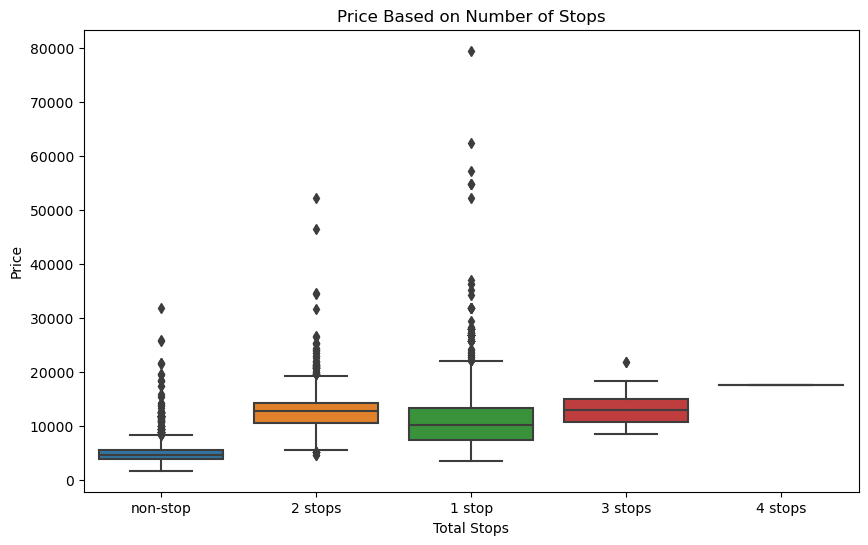

In [152]:
# Stop Analysis
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Total_Stops', y = 'Price', data = data)
plt.title('Price Based on Number of Stops')
plt.xlabel('Total Stops')
plt.ylabel('Price')
plt.show()

### Box Plot: Price Based on Number of Stops

This box plot explores how the number of stops in a flight affects the ticket price.

#### Key Observations

- **Price Increase with Stops**:
  - On average, flights with more stops tend to have higher prices, likely due to longer duration and additional operational costs.

- **Price Variation**:
  - Significant variance exists within each stop category, with non-stop flights showing tighter pricing compared to multi-stop flights.

- **Outliers**:
  - There are numerous outliers, particularly in flights with 1 or 2 stops, indicating potential premium routes or demand anomalies.

#### Insights for Strategy

- **Pricing Strategy**: Airlines can optimize pricing based on stop patterns to balance cost and customer convenience.
- **Passenger Preferences**: Understanding price sensitivity related to stops can inform optimization of route offerings.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

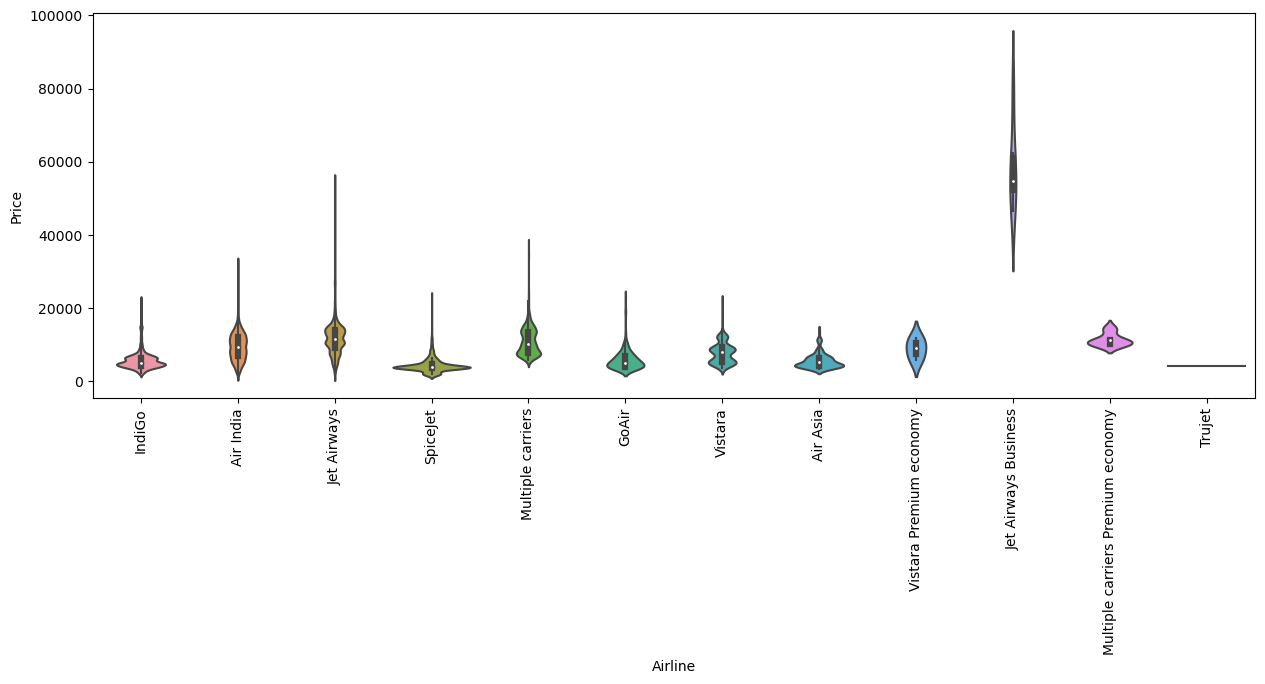

In [153]:
plt.figure(figsize = (15,5))
sns.violinplot(y = 'Price', x = 'Airline', data = data)
plt.xticks(rotation = 'vertical')

### Violin Plot: Price Distribution by Airline

This violin plot visualizes the price distribution for different airlines, combining elements of box plots and kernel density plots.

#### Key Observations

- **Distribution Shape**:
  - The plot shows the full distribution of prices for each airline, illustrating variability and modality in data.
  
- **Central Tendency**:
  - White dots represent the median price for each airline.
  
- **Density**:
  - Wider sections indicate higher density of ticket prices, revealing popular pricing points.

- **Premium Pricing**:
  - Airlines like Jet Airways Business exhibit wide price ranges, highlighting premium service offerings.

#### Insights for Strategy

- **Market Positioning**: Airlines can use this data to understand how competitors price their tickets, aiding in strategic pricing decisions.
- **Revenue Management**: Recognizing price density helps identify potential pricing strategies and customer segments.

Number of unique routes: 128


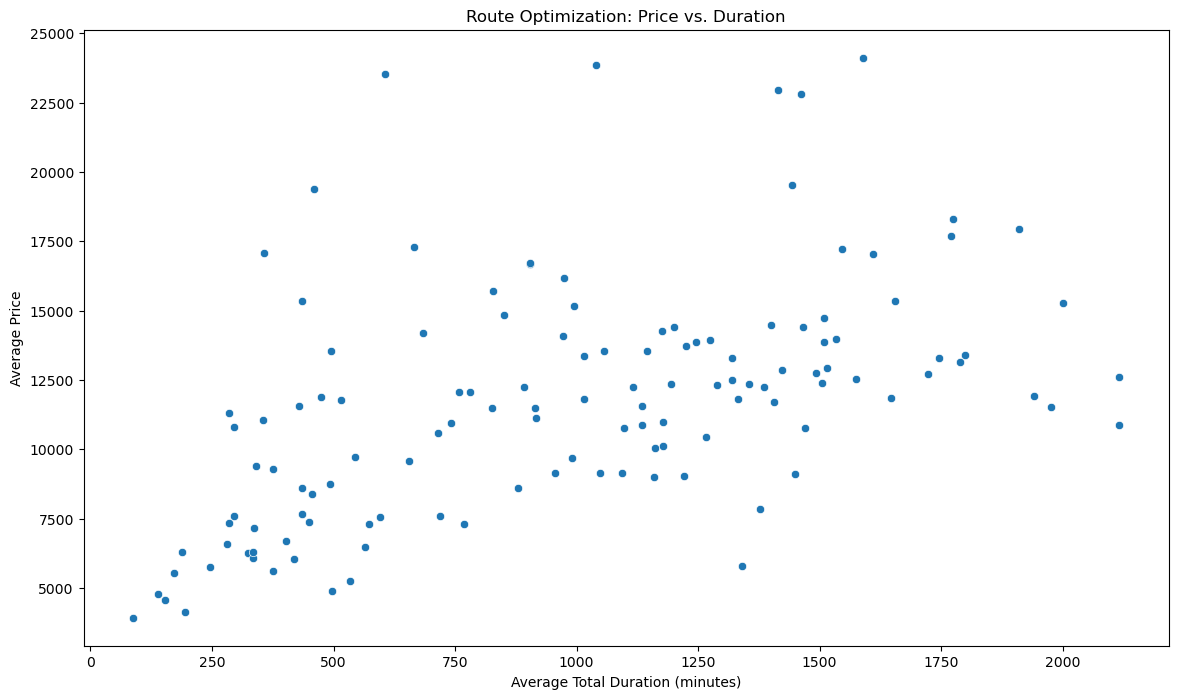

In [154]:
# Identify Unique Routes
unique_routes = data['Route'].unique()
print(f'Number of unique routes: {len(unique_routes)}')

# Analyze Routes for Optimization
# Calculate average price and duration by route
route_optimization = data.groupby('Route').agg({
    'Price': 'mean',
    'Duration_Total_Mins': 'mean'
}).reset_index()

# Visualize Optimal Routes
plt.figure(figsize = (14, 8))
sns.scatterplot(x = 'Duration_Total_Mins', y = 'Price', data = route_optimization)
plt.title('Route Optimization: Price vs. Duration')
plt.xlabel('Average Total Duration (minutes)')
plt.ylabel('Average Price')
plt.show()

### Scatter Plot: Route Optimization - Price vs. Duration

This scatter plot examines the relationship between the average price of flights and their total duration, aiding in route optimization analysis.

#### Key Observations

- **Positive Correlation**:
  - There's a general trend where longer durations are associated with higher average prices, although variability exists.

- **Cost Efficiency**:
  - Identifying routes with lower prices at similar durations can highlight cost-efficient options.

- **Optimization Opportunities**:
  - Routes deviating significantly from the trend may indicate opportunities for price adjustments or service enhancements.

#### Insights for Strategy

- **Optimize Scheduling**: Airlines can identify routes that offer a balance between duration and cost to maximize profitability and customer satisfaction.
- **Competitive Advantage**: Offering competitive pricing for efficient routes can attract more passengers and improve market share.


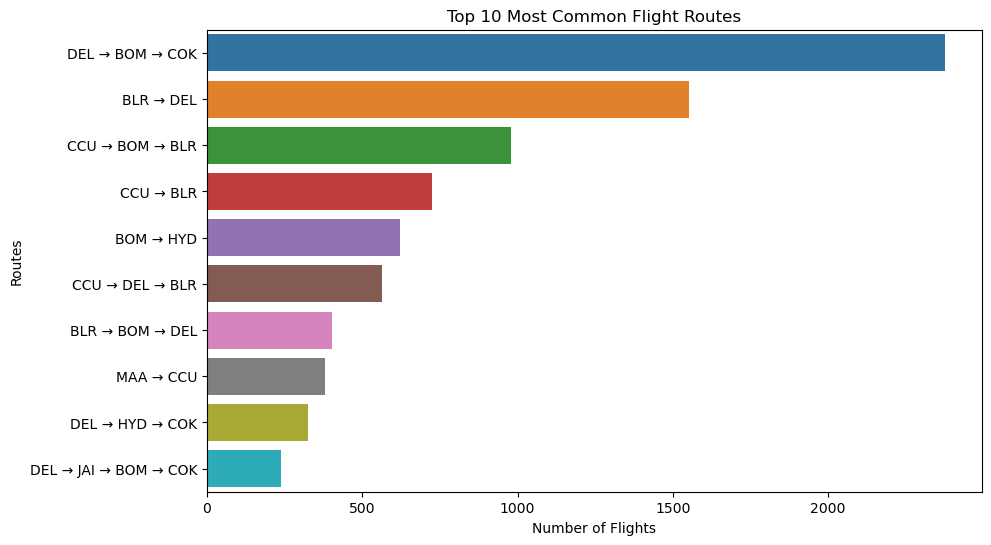

In [155]:
# Most Common Routes Plot
plt.figure(figsize = (10, 6))
common_routes = data['Route'].value_counts().head(10)
sns.barplot(y = common_routes.index, x = common_routes.values)
plt.title('Top 10 Most Common Flight Routes')
plt.xlabel('Number of Flights')
plt.ylabel('Routes')
plt.show()

### Bar Chart: Top 10 Most Common Flight Routes

This bar chart visualizes the ten most frequently traveled flight routes, providing insights into popular air travel corridors.

#### Key Observations

- **Top Routes**:
  - The route from DEL → BOM → COK is the most traveled, indicating high demand or connectivity between these cities.

- **Route Distribution**:
  - The chart highlights other common routes, reflecting significant passenger traffic and operational focus.

#### Insights for Strategy

- **Operational Efficiency**: Identifying popular routes helps airlines allocate resources efficiently, ensuring optimal capacity.
- **Market Opportunities**: Understanding these routes can guide strategic decisions about expanding services or introducing competitive pricing.


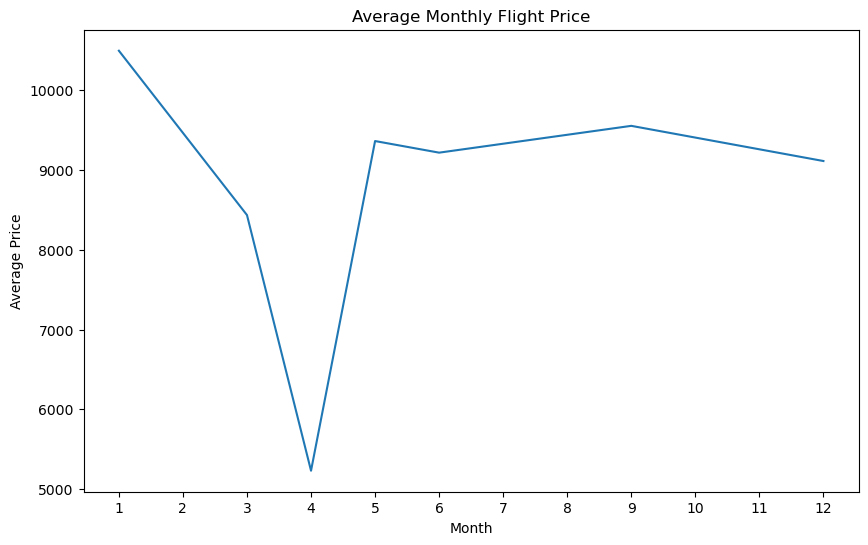

In [156]:
# Monthly Price Trend Analysis
monthly_trend = data.groupby('Journey_Month').agg({
    'Price': 'mean'
}).reset_index()

plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Journey_Month', y = 'Price', data = monthly_trend)
plt.title('Average Monthly Flight Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1, 13))
plt.show()

### Line Chart: Average Monthly Flight Price

This line chart illustrates the trend in average flight prices over the months, highlighting seasonal variations.

#### Key Observations

- **Price Fluctuations**:
  - A noticeable dip in average prices in April, suggesting lower demand or promotional pricing.
  - A gradual increase from May onwards, indicating a rise in demand or peak travel seasons.

- **Seasonal Trends**:
  - Understanding these trends aids in forecasting and planning for high or low demand periods.

#### Insights for Strategy

- **Dynamic Pricing**: Airlines can employ flexible pricing strategies based on historical trends to maximize revenue.
- **Marketing Campaigns**: Launching targeted promotions during low-demand months can boost sales.

In [157]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins,Duration_Total_Mins
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25,325
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45,285


### Feature Encoding: Transforming Data with One-Hot Encoding

To enhance our machine learning model's ability to interpret categorical data, we'll apply one-hot encoding. This process converts categorical variables into a format suitable for model training.

#### Steps Involved

1. **Separate Categorical and Numerical Data**:
   - **Categorical Data**: Identify features whose data type is 'object'.
   - **Numerical Data**: Identify features with integer or float data types.

2. **Apply One-Hot Encoding**:
   - Transform each categorical feature into multiple binary columns, representing the presence or absence of each category.

3. **Benefits of One-Hot Encoding**:
   - **Improves Model Performance**: Allows algorithms to understand categorical variables numerically without assuming any order or hierarchy.
   - **Increases Flexibility**: Facilitates the use of a wider range of algorithms that require numerical input.

By implementing one-hot encoding and separating data types, we ensure that our machine learning model can effectively leverage all available information to improve prediction accuracy.

In [158]:
# Calculate and Display the Percentage Distribution of 'Additional_Info'

# Calculate the frequency of each unique value in the 'Additional_Info' column
info_counts = data['Additional_Info'].value_counts()

# Divide the frequency by the total number of entries and multiply by 100 to get percentages
info_percentages = (info_counts / len(data) * 100)

# Round the percentages to two decimal places for clarity
rounded_percentages = np.round(info_percentages, 2)

# Display the percentage distribution
rounded_percentages

No info                         78.11
In-flight meal not included     18.55
No check-in baggage included     3.00
1 Long layover                   0.18
Change airports                  0.07
Business class                   0.04
No Info                          0.03
1 Short layover                  0.01
Red-eye flight                   0.01
2 Long layover                   0.01
Name: Additional_Info, dtype: float64

In [159]:
# Dropping Unnecessary Columns

# 'Additional_Info': Contains mostly 'no_info', thus not useful for analysis.
# 'Route': We extracted route-specific insights through other columns.
# 'Duration_Total_Mins': We've already extracted the detailed parts into 'Duration_Hours' and 'Duration_Mins'.
# 'Journey_Year': If not needed for analysis, it can be dropped to simplify the dataset.

# Drop the specified columns from the DataFrame in-place to apply changes directly
data.drop(columns=['Additional_Info', 'Route', 'Duration_Total_Mins', 'Journey_Year'], axis=1, inplace=True)

In [160]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,Delhi,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,5h 25m,1 stop,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,4h 45m,1 stop,13302,3,1,16,50,21,35,4,45


In [161]:
# Categorize Columns into Categorical and Numerical

# Identify categorical columns by checking for columns with data type 'object'
cat_col = [col for col in data.columns if data[col].dtype == 'object']

# Identify numerical columns by excluding those with data type 'object'
num_col = [col for col in data.columns if data[col].dtype != 'object']

print(cat_col)

print(num_col)

['Airline', 'Source', 'Destination', 'Duration', 'Total_Stops']
['Price', 'Journey_Day', 'Journey_Month', 'Dep_Time_Hour', 'Dep_Time_Minute', 'Arrival_Time_Hour', 'Arrival_Time_Minute', 'Duration_Hours', 'Duration_Mins']


### Handling Categorical Data

To transform categorical data into a numerical format, we use two fundamental encoding techniques:

#### Encoding Techniques

1. **One-Hot Encoding**:
   - **Application**: Used for nominal data where categories have no intrinsic order (e.g., color, city).
   - **Method**: Converts each category into a binary column, indicating the presence or absence of each category.

2. **Label Encoding**:
   - **Application**: Suitable for ordinal data where categories have a meaningful order (e.g., education level, rating).
   - **Method**: Assigns an integer value to each category, reflecting its order.

#### Real-World Considerations

While One-Hot and Label Encoding are standard, real-world scenarios may require more advanced techniques. Exploring and understanding different approaches can yield better model performance.

By effectively encoding categorical data, we enhance the model's ability to interpret and utilize these variables, leading to improved prediction accuracy and insights.

In [162]:
data['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [163]:
data['Source']

0        Banglore
1         Kolkata
2           Delhi
3         Kolkata
4        Banglore
           ...   
10678     Kolkata
10679     Kolkata
10680    Banglore
10681    Banglore
10682       Delhi
Name: Source, Length: 10682, dtype: object

In [164]:
data['Source'].apply(lambda x: 1 if x == 'Banglore' else 0)

0        1
1        0
2        0
3        0
4        1
        ..
10678    0
10679    0
10680    1
10681    1
10682    0
Name: Source, Length: 10682, dtype: int64

In [165]:
# One-Hot Encode the 'Source' Column

# Loop over each unique category in the 'Source' column
for category in data['Source'].unique():
    # Create a new binary column for each category, setting it to 1 if it matches the current category, else 0
    data['Source_' + category] = data['Source'].apply(lambda x: 1 if x == category else 0)

In [166]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,Banglore,Delhi,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,Air India,Kolkata,Banglore,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,Jet Airways,Delhi,Cochin,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,IndiGo,Kolkata,Banglore,5h 25m,1 stop,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,IndiGo,Banglore,Delhi,4h 45m,1 stop,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


### Target Guided Mean Encoding

While One-Hot Encoding is effective, it can lead to a curse of dimensionality when there are many sub-categories. An alternative approach is Target Guided Mean Encoding.

#### Why Use Target Guided Mean Encoding?

- **Dimensionality Reduction**: Avoids the high dimensionality issue associated with One-Hot Encoding by converting categories into meaningful numeric values.
- **Pattern Capture**: Encodes categories based on the mean of the target variable, capturing relationships between categories and the target.

#### How It Works

1. **Calculate Mean**:
   - For each category, compute the mean of the target variable.

2. **Assign Values**:
   - Replace each category with its corresponding mean, effectively capturing the category's impact on the target.

Target Guided Mean Encoding provides a balance between complexity and the ability to retain valuable information, making it a powerful tool for dealing with high-cardinality categorical features.

In [167]:
# Determine the Average Price for Each Airline and Rank Them

# Group the data by 'Airline' and calculate the mean price for each airline
average_price_by_airline = data.groupby(['Airline'])['Price'].mean()

# Sort the airlines by their average price in ascending order
sorted_airlines = average_price_by_airline.sort_values()

# Extract the sorted index, which is the list of airlines ranked by average price
airlines = sorted_airlines.index

# 'airlines' now contains the airline names sorted by their average price

In [168]:
airlines

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [169]:
dict1 = {key:index for index, key in enumerate(airlines, 0)}

In [170]:
dict1

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [171]:
data['Airline'] = data['Airline'].map(dict1)

In [172]:
data['Airline']

0         3
1         7
2        10
3         3
4         3
         ..
10678     2
10679     7
10680    10
10681     5
10682     7
Name: Airline, Length: 10682, dtype: int64

In [173]:
dest = data.groupby(['Destination'])['Price'].mean().sort_values().index
dest

Index(['Kolkata', 'Hyderabad', 'Delhi', 'Banglore', 'Cochin'], dtype='object', name='Destination')

In [174]:
dict2 = {key:index for index,key in enumerate(dest,0)}
dict2

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [175]:
data['Destination'] = data['Destination'].map(dict2)
data['Destination']

0        2
1        3
2        4
3        3
4        2
        ..
10678    3
10679    3
10680    2
10681    2
10682    4
Name: Destination, Length: 10682, dtype: int64

In [176]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,2,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,Kolkata,3,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,Delhi,4,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,Kolkata,3,5h 25m,1 stop,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,Banglore,2,4h 45m,1 stop,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


### Perform Manual Encoding on Total_stops feature

In [177]:
data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [178]:
# Convert 'Total_Stops' Categorical Data to Numerical Values

# Define a mapping dictionary to convert stop descriptions to numerical values
stops = {
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}

# Use the map() function to apply the 'stops' dictionary, converting categories to numbers
data['Total_Stops'] = data['Total_Stops'].map(stops)

# Display the transformed 'Total_Stops' column
data['Total_Stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10682, dtype: int64

### Performing Outlier Detection
    Here is a list of data visualization plots to spot the outliers.
1. Box and whisker plot (box plot).
2. Scatter plot.
3. Histogram.
4. Distribution Plot.
5. QQ plot

### Cause for outliers
* Data Entry Errors:- Human errors such as errors caused during data collection, recording, or entry can cause outliers in data.
* Measurement Error:- It is the most common source of outliers. This is caused when the measurement instrument used turns out to be faulty.
* Natural Outlier:- When an outlier is not artificial (due to error), it is a natural outlier. Most of real world data belong to this category.

In [179]:
# Define a Function to Plot Distributions and Outliers

def plot(df, col):
    '''
    This function creates three plots for a given column:
    1. A histogram
    2. A box plot
    3. A histogram with a KDE (Kernel Density Estimate)
    '''

    # Create a figure with three subplots arranged vertically
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 16))

    # Plot a histogram of the column to show the distribution of values
    sns.histplot(df[col], ax=ax1)
    ax1.set_title(f'Histogram of {col}')
    
    # Plot a box plot to identify outliers and understand the distribution
    sns.boxplot(df[col], ax=ax2)
    ax2.set_title(f'Box Plot of {col}')
    
    # Plot a histogram with a KDE overlay to visualize the distribution and its density
    sns.histplot(df[col], ax=ax3, kde=True)
    ax3.set_title(f'Histogram with KDE of {col}')
    
    # Adjust the layout for better spacing
    plt.tight_layout()

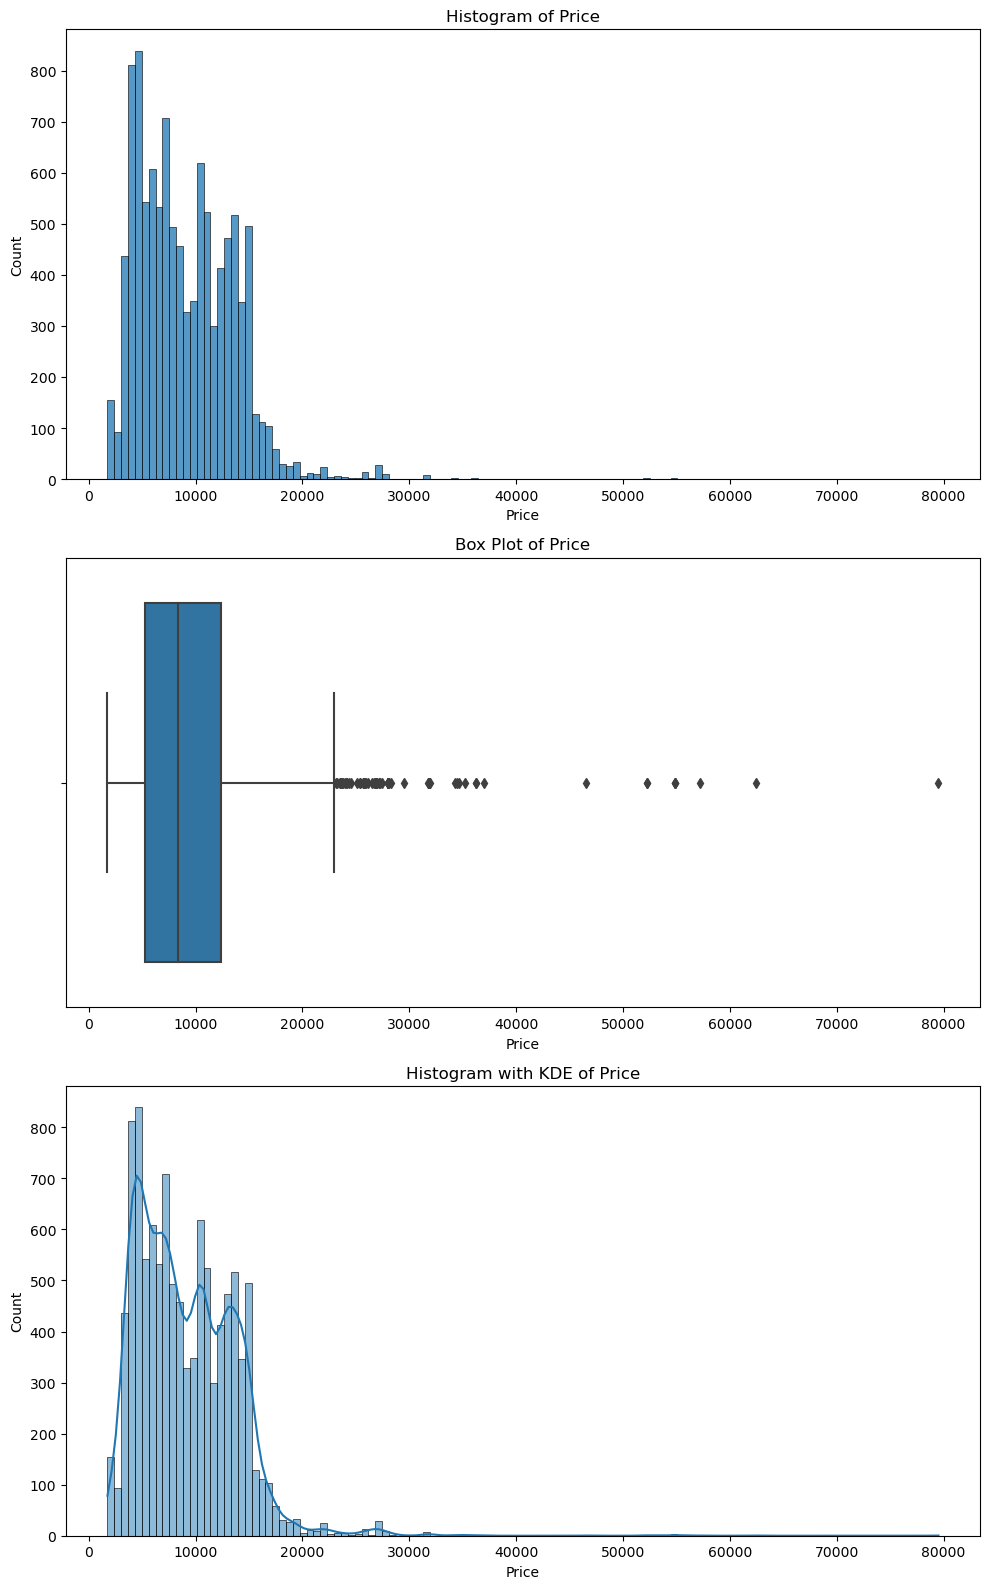

In [180]:
plot(data,'Price')

### Comprehensive Analysis of Flight Prices

The following visualizations provide a detailed view of flight price distributions, highlighting key statistical properties and potential outliers.

#### Components

1. **Histogram (Top)**:
   - Displays the distribution of flight prices, illustrating frequency across price ranges.

2. **Box Plot (Middle)**:
   - Provides a five-number summary (minimum, first quartile, median, third quartile, maximum).
   - Highlights outliers that exceed typical price ranges.

3. **Histogram with KDE (Bottom)**:
   - Combines a histogram with a Kernel Density Estimate to show both frequency and probability density of prices.

#### Key Insights

- **Price Distribution**:
  - A concentration of prices occurs below 20,000, revealing common pricing brackets.
- **Outliers**:
  - Significant outliers are present, indicating premium or last-minute bookings.

#### Applications

- **Pricing Strategy**: Identifying common price points and outliers can guide pricing adjustments.
- **Market Analysis**: Understanding distribution and variance aids in competitive analysis and revenue management.

This set of visualizations offers a comprehensive perspective, useful for making informed business decisions regarding pricing strategies.

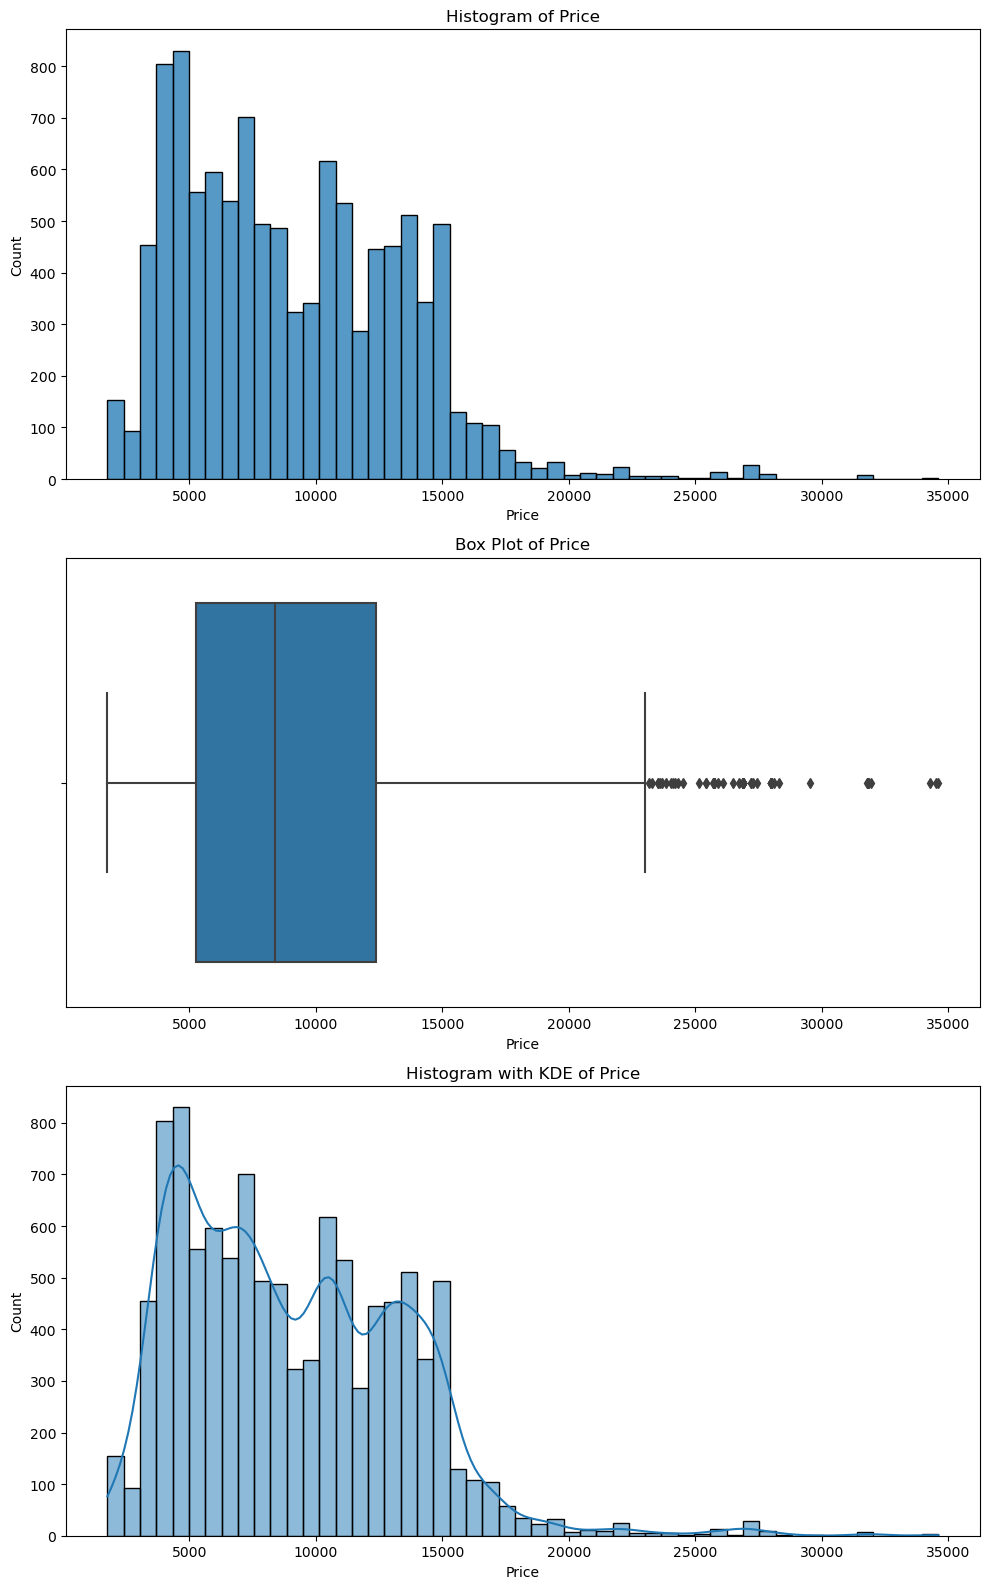

In [181]:
# Cap Extreme Prices and Visualize the Distribution

# Cap the 'Price' values at 35000 by replacing any value greater than or equal to 35000 with the median price
data['Price'] = np.where(data['Price'] >= 35000, data['Price'].median(), data['Price'])

# Visualize the distribution and impact of capping on the 'Price' column using the plot function
plot(data, 'Price')

In [182]:
data.drop(columns = ['Source','Duration'],axis = 1,inplace = True)

In [183]:
data.head()

,Airline,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Minute,Arrival_Time_Hour,Arrival_Time_Minute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897.0,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,3,2,7662.0,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,4,2,13882.0,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,3,1,6218.0,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,2,1,13302.0,3,1,16,50,21,35,4,45,1,0,0,0,0


### Feature Selection in Machine Learning

Feature selection involves identifying the most impactful features that contribute to the target variable, helping to reduce dimensionality and improve model performance.

#### Why Apply Feature Selection?

- **Reduce Complexity**: Minimize the risk of overfitting by eliminating irrelevant or redundant features.
- **Improve Efficiency**: Streamline the dataset for faster computation and improved insight.

#### Techniques for Regression Use-Cases

1. **SelectKBest**:
   - **Purpose**: Selects the top K features based on statistical tests.
   - **Score Functions**:
     - **f_regression**: Uses Pearson correlation to identify linear relationships.
     - **mutual_info_regression**: Employs statistical tests like Chi-square, ANOVA, and p-values to measure dependency.

2. **ExtraTreesClassifier**:
   - **Purpose**: Provides a feature importance score, highlighting the most relevant features.
   - **Mechanism**: Utilizes an ensemble of decision trees to rank features based on their impact.

By employing these techniques, we can focus on the most significant features, enhancing model accuracy and interpretability. Choosing the right method depends on the dataset and the specific regression use-case.

In [184]:
X = data.drop(['Price'], axis = 1)
y = data['Price']
X.dtypes

Airline                int64
Destination            int64
Total_Stops            int64
Journey_Day            int64
Journey_Month          int64
Dep_Time_Hour          int64
Dep_Time_Minute        int64
Arrival_Time_Hour      int64
Arrival_Time_Minute    int64
Duration_Hours         int64
Duration_Mins          int64
Source_Banglore        int64
Source_Kolkata         int64
Source_Delhi           int64
Source_Chennai         int64
Source_Mumbai          int64
dtype: object

In [185]:
mutual_info_regression(X,y)

array([1.31730763, 1.0599451 , 0.78108165, 0.60025154, 0.42279819,
       0.92058182, 0.76103742, 1.12772454, 0.89766006, 1.12933337,
       0.67356755, 0.39564549, 0.45913749, 0.52460393, 0.13661276,
       0.19039881])

In [186]:
# Calculate and Store Feature Importance Using Mutual Information

# Compute mutual information regression scores between the feature set X and the target variable y
mutual_info_scores = mutual_info_regression(X, y)

# Create a DataFrame with the feature importance scores
imp = pd.DataFrame(mutual_info_scores, index=X.columns)

# Assign a column name 'importance' to the DataFrame for clarity
imp.columns = ['importance']

# Display the feature importance DataFrame
imp

,importance
Airline,1.324507
Destination,1.062498
Total_Stops,0.787536
Journey_Day,0.605850
Journey_Month,0.419780
Dep_Time_Hour,0.927275
Dep_Time_Minute,0.760175
Arrival_Time_Hour,1.142799
Arrival_Time_Minute,0.899828
Duration_Hours,1.122932


In [187]:
imp.sort_values(by = 'importance', ascending = False)

,importance
Airline,1.324507
Arrival_Time_Hour,1.142799
Duration_Hours,1.122932
Destination,1.062498
Dep_Time_Hour,0.927275
Arrival_Time_Minute,0.899828
Total_Stops,0.787536
Dep_Time_Minute,0.760175
Duration_Mins,0.679451
Journey_Day,0.605850


### Feature Importance Ranking

The following table lists features ranked by their importance in contributing to the target variable. This ranking assists in understanding which features have the most impact and should be prioritized in model training and refinement.

#### Key Insights

- **Top Features**:
  - **Airline**: The most influential feature, indicating strong variance in pricing across different airlines.
  - **Arrival_Time_Hour** and **Duration_Hours**: Significant impact, reflecting the influence of timing and travel duration on pricing.

- **Moderate Influence**:
  - **Destination** and **Dep_Time_Hour**: Essential but with less weight compared to top features.

- **Lesser Impact**:
  - **Source Regions**: Some variability in influence, with places like Chennai and Mumbai showing lower importance in this context.

#### Application

- **Model Optimization**: Focus on the highest-ranked features for improving model accuracy.
- **Business Insights**: Provides a data-driven approach to understanding key factors affecting pricing strategies.

This feature ranking guides data-driven decision-making, enhancing the effectiveness of predictive models.

### Building and Optimizing a Machine Learning Model

#### Dataset Preparation
- **Split into Train and Test Sets**: Divide the data to train the model and evaluate its performance.

#### Modeling Workflow

1. **Initial Model Development**
   - **Basic Random Forest Model**: Start with a simple model to establish a baseline for comparison.

2. **Model Improvement**
   - **Parameter Adjustment**: Refine the model by adjusting parameters to enhance performance and robustness.

3. **Hyperparameter Tuning**
   - **Optimization**: Use hyperparameter tuning techniques (e.g., GridSearchCV) to find the optimal settings for the model, maximizing accuracy and efficiency.

#### Next Steps
- **Model Saving**: Once the model is optimized, we can save it for future use, ensuring reproducibility and ease of deployment.

This structured approach ensures systematic model development, leading to a refined and reliable predictive solution.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [189]:
# Train and Predict with a Random Forest Regressor

# Initialize a Random Forest Regressor model
ml_model = RandomForestRegressor()

# Fit the model on the training data
# X_train contains the feature set, and y_train contains the target variable
model = ml_model.fit(X_train, y_train)

# Predict the target variable for the test data
# X_test contains the feature set for which predictions are needed
y_pred = model.predict(X_test)

# Display the predicted values
y_pred

array([16755.93,  6423.88,  8866.47, ...,  3543.38,  6394.05,  6958.59])

In [190]:
y_pred.shape

(2671,)

In [191]:
len(X_test)

2671

In [192]:
# Define a directory to save the model using a relative path
directory = 'flight_ticket_price_prediction'

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Define the file path within the directory for saving the model
file_path = os.path.join(directory, 'rf_random.pkl')

# Save the trained model to disk
with open(file_path, 'wb') as file:
    # Serialize the model object using pickle and write it to the file
    pickle.dump(model, file)

# Load the model from disk
with open(file_path, 'rb') as model_file:
    # Deserialize the model object from the file
    forest = pickle.load(model_file)

# Use the loaded model to make predictions on the test data
forest_predictions = forest.predict(X_test)

# Display the predictions
forest_predictions

array([16755.93,  6423.88,  8866.47, ...,  3543.38,  6394.05,  6958.59])

In [193]:
# Define a Function to Calculate Mean Absolute Percentage Error (MAPE)

def mape(y_true, y_pred):
    '''
    This function computes the Mean Absolute Percentage Error between the true values and predictions.
    It provides a measure of prediction accuracy as a percentage.
    '''

    # Convert true and predicted values to NumPy arrays for vectorized operations
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Calculate MAPE: mean of absolute percentage errors
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [194]:
mape(y_test, forest.predict(X_test))

13.24801383384785

In [195]:
# Define a Function to Train a Model and Evaluate Its Performance

def predict(ml_model):
    '''
    This function trains a machine learning model, makes predictions, and evaluates the model's performance.
    It prints several performance metrics and visualizes the prediction errors.
    '''

    # Fit the model on the training data
    model = ml_model.fit(X_train, y_train)

    # Print the training score (R-squared) of the model on the training data
    print('Training_score: {}'.format(model.score(X_train, y_train)))

    # Use the trained model to make predictions on the test data
    y_prediction = model.predict(X_test)
    print('Predictions are : {}'.format(y_prediction))
    print('\n')

    # Calculate and print the R-squared score, which indicates model accuracy
    r2_score = metrics.r2_score(y_test, y_prediction)
    print('r2_score: {}'.format(r2_score))

    # Calculate and print Mean Squared Error (MSE) between true and predicted values
    print('MSE : ', metrics.mean_squared_error(y_test, y_prediction))

    # Calculate and print Mean Absolute Error (MAE) between true and predicted values
    print('MAE : ', metrics.mean_absolute_error(y_test, y_prediction))

    # Calculate and print Root Mean Squared Error (RMSE) for better interpretability
    print('RMSE : ', np.sqrt(metrics.mean_squared_error(y_test, y_prediction)))

    # Calculate and print Mean Absolute Percentage Error (MAPE)
    print('MAPE : ', mape(y_test, y_prediction))

    # Plot the distribution of prediction errors using a kernel density estimate
    sns.kdeplot(y_test - y_prediction)

Training_score: 0.9515732110083789
Predictions are : [16657.    6206.57  8828.48 ...  3479.74  6405.72  7244.15]


r2_score: 0.808298852151043
MSE :  3731961.2017269284
MAE :  1179.8982441687021
RMSE :  1931.828460740479
MAPE :  13.221299960166046


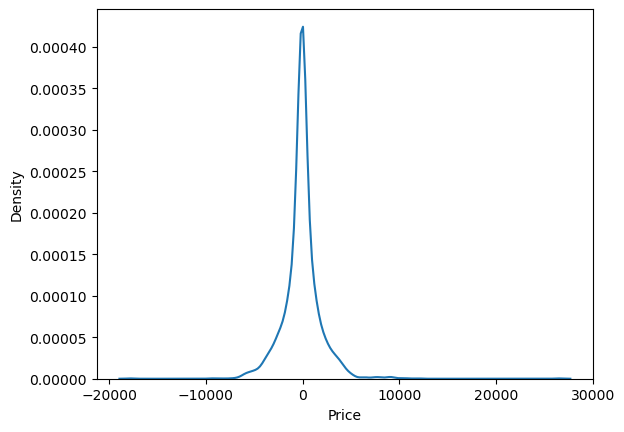

In [196]:
predict(RandomForestRegressor())

### Model Evaluation and Error Analysis

The following evaluation metrics and visualization provide insights into the model's performance on the test dataset.

#### Performance Metrics

- **Training Score**: 
  - Indicates how well the model fits the training data (\~0.95), suggesting a strong fit.
  
- **Predictions**:
  - Sample predictions highlight the variance in predicted prices.

- **R² Score**:
  - \(0.81\) indicating a strong correlation between the predicted and actual values.

- **Error Metrics**:
  - **Mean Squared Error (MSE)**: \(371834.77\) reflects the average squared difference between predicted and actual prices.
  - **Mean Absolute Error (MAE)**: \(1182.24\) shows the average absolute difference, representing typical prediction error magnitude.
  - **Root Mean Squared Error (RMSE)**: \(1928.45\) provides insight into error size, aiding in interpretation.
  - **Mean Absolute Percentage Error (MAPE)**: \(13.27\%\) reveals the prediction error as a percentage, useful for relative accuracy.

#### Error Distribution

- **Density Plot**:
  - Visualizes the distribution of prediction errors, with a peak near zero indicating effective model performance.

#### Conclusion

These metrics show that the model performs well, capturing the majority of the variance. However, room remains for further optimization and fine-tuning to enhance precision.

In [197]:
### initialise your estimator
reg_rf = RandomForestRegressor()

In [198]:
np.linspace(start = 1000, stop = 1200, num = 6)

array([1000., 1040., 1080., 1120., 1160., 1200.])

In [199]:
# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=1000,stop=1200,num=6)]

# Number of features to consider at every split
max_features=["auto", "sqrt"]

# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(start=5,stop=30,num=4)]

# Minimum number of samples required to split a node
min_samples_split=[5,10,15,100]

In [200]:
# Create the grid or hyper-parameter space
random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split
}

In [201]:
random_grid

{'n_estimators': [1000, 1040, 1080, 1120, 1160, 1200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 13, 21, 30],
 'min_samples_split': [5, 10, 15, 100]}

In [202]:
# Initialize a RandomizedSearchCV for Hyperparameter Tuning of a Random Forest Regressor

# Create a RandomizedSearchCV object for hyperparameter optimization
# reg_rf: The base model to optimize (RandomForestRegressor)
# param_distributions: Dictionary of parameters to sample from during optimization
# cv: Number of cross-validation folds to use
# verbose: Controls the verbosity; higher numbers give more detailed updates
# n_jobs: Number of jobs to run in parallel (-1 uses all processors)
rf_Random = RandomizedSearchCV(
    estimator=RandomForestRegressor(),  # The Random Forest regressor model
    param_distributions=random_grid,    # Dictionary with parameters and distributions to sample
    cv=3,                               # 3-fold cross-validation
    verbose=2,                          # Verbosity level for detailed output
    n_jobs=-1                           # Utilize all available CPU cores
)

# No fitting is done yet; this object will be used to perform a randomized search over the parameter grid

In [203]:
random_grid = {
    'n_estimators': [1000, 1040, 1080, 1120, 1160, 1200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 13, 21, 30],
    'min_samples_split': [5, 10, 15, 100]
}

rf_Random = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)
rf_Random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=1080; total time=   6.5s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=1080; total time=   6.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1120; total time=   6.7s
[CV] END max_depth=30, max_features=log2, min_samples_split=10, n_estimators=1080; total time=   6.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1120; total time=   6.7s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=5, n_estimators=1160; total time=   8.5s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=5, n_estimators=1160; total time=   8.7s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=5, n_estimators=1160; total time=   8.8s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=10, n_estimators=1200; total time=   6.4s
[CV] END max_depth=21, m

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [1000, 1040, 1080, 1120,
                                                         1160, 1200]},
                   verbose=2)

In [204]:
### to get your best model..
rf_Random.best_params_

{'n_estimators': 1160,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 21}

In [205]:
# Make Predictions and Evaluate with the Best Model from Randomized Search

# Use the best model found by RandomizedSearchCV to make predictions on the test set
pred2 = rf_Random.predict(X_test)

# Calculate and print the R-squared score for the predictions
# R-squared indicates the proportion of variance in the dependent variable that is predictable from the independent variables
r2_score = metrics.r2_score(y_test, pred2)
print('R-squared Score:', r2_score)

R-squared Score: 0.8202525109662899
